# Introduction to CREsted

In this introductory notebook, we will train a topic classification model and inspect the results.

In [1]:
import crested

2024-06-14 13:06:31.199599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 13:06:39.655458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 13:06:42.632503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-14 13:06:46.241521: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at htt

We can use the {func}`~crested.import_topics` function to import regions per topic BED files and a consensus regions BED file (output from running [pycistopic](https://pycistopic.readthedocs.io/en/latest/) into an {class}`anndata.AnnData` object,
with the imported topics as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

Optionally, provide a chromsizes file to filter out regions that are not within the chromsizes. 

In [2]:
adata = crested.import_topics(
    topics_folder="/staging/leuven/stg_00002/lcb/lmahieu/projects/DeepTopic/biccn_test/otsu",
    regions_file="/staging/leuven/stg_00002/lcb/lmahieu/projects/DeepTopic/biccn_test/consensus_peaks_bicnn.bed",
    # topics_subset=["topic_1", "topic_2"], # optional subset of topics to import
)
adata

2024-06-14T13:08:55.868102+0200 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes


2024-06-14T13:09:24.606972+0200 WARNING 107610 consensus regions are not open in any topic. Removing them from the AnnData object. Disable this behavior by setting 'remove_empty_regions=False'


View of AnnData object with n_obs × n_vars = 80 × 439383
    obs: 'file_path', 'n_open_regions'
    var: 'n_topics', 'chr', 'start', 'end'

To train a model, we'll need to add a *split* column to our dataset, which we can do using `crested.pp.train_val_test_split()`.  
This will add a column to the `AnnData.obs` with the split type for each region.

In [3]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var

split
train    354013
val       45113
test      40257
Name: count, dtype: int64


,n_topics,chr,start,end,split
region,,,,,
chr1:3094805-3095305,5,chr1,3094805,3095305,train
chr1:3112174-3112674,1,chr1,3112174,3112674,train
chr1:3113534-3114034,2,chr1,3113534,3114034,train
chr1:3119746-3120246,8,chr1,3119746,3120246,train
chr1:3120272-3120772,9,chr1,3120272,3120772,train
...,...,...,...,...,...
chrX:169824955-169825455,1,chrX,169824955,169825455,train
chrX:169827652-169828152,1,chrX,169827652,169828152,train
chrX:169838234-169838734,2,chrX,169838234,169838734,train


## Fit and Evaluate

The entire CREsted workflow is built around the {func}`~crested.tl.Crested` class.
This class has a couple of required arguments:
- `data`: the {class}`~crested.tl.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`~tf.keras.Model` object containing the model architecture.
- `config`: the {class}`~crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.

#### Data

We'll start by initializing the {class}`~crested.tl.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to suuply are the `adata` object, the `genome` object, and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...)

In [4]:
from crested.tl.data import AnnDataModule

datamodule = AnnDataModule(
    adata,
    genome_file="/staging/leuven/res_00001/genomes/10xgenomics/CellRangerARC/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa",
    batch_size=256,
)

#### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide any model you like.
Altneratively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

For example, to use the architecture that was used to train the deepMEL, etc models, you can load the {func}`~crested.tl.zoo.deeptopic_cnn` model.

In [5]:
# Load deeptopic_cnn architecture for a dataset with 500bp regions and 80 topics
from crested.tl.zoo import deeptopic_cnn

model_architecture = deeptopic_cnn(seq_len=500, num_classes=80)

#### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`~crested.tl.default_configs` function.  

In [39]:
# Load the default configuration for training a topic classication model
from crested.tl import default_configs, TaskConfig

config = default_configs("topic_classification")
print(config)

# If you want to change some small parameters to an existing config, you can do it like this
# For example, the default learning rate is 0.001, but you want to change it to 0.0001
config.optimizer.learning_rate = 0.0001

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x151ec9128610>, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x151ec90a6410>, metrics=[<AUC name=auROC>, <AUC name=auPR>, <CategoricalAccuracy name=categorical_accuracy>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

In [38]:
# Create your own configuration
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [
    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
    )
]
config = TaskConfig(optimizer, loss, metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x151ec9048a10>, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x151ec912b590>, metrics=[<AUC name=auc_3>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, ...).

In [43]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="my_project",
    logger="wandb",
)

In [ ]:
# train the model
trainer.fit(epochs=100)

## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the {func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our data.

In [46]:
evaluator = crested.tl.Crested(data=datamodule)

# load an existing model
evaluator.load_model(
    "/staging/leuven/stg_00002/lcb/lmahieu/projects/CREsted/test-crested/2024-06-14_11:05/checkpoints/25.keras"
)

In [47]:
# evaluate the model on the test set
evaluator.test()

2024-06-14T13:59:05.958608+0200 WARNING No GPUs available.
INFO:tensorflow:Converted call: <function _from_generator.<locals>.flat_map_fn at 0x151f204056c0>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x151f204056c0>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x151f20405440>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x151f20405440>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function _from_generator.<locals>.generator_next_fn at 0x151f20405580>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x151f20405580>
   

## Predict

After training, we can also use the {meth}`~crested.tl.Crested.predict` method to predict the labels for new data and add them as a layer to the `AnnData` object.  
A common use case is to compare the predicted labels to the true labels for multiple trained models to see how well they compare.  

We can initiate a new Crested object (if you have different data) or use the existing one.  
Here we continue with the existing one since we'll use the same data as we trained on.

In [50]:
# add predictions for model 1 to the adata
evaluator.load_model(
    "/staging/leuven/stg_00002/lcb/lmahieu/projects/CREsted/test-crested/2024-06-14_11:05/checkpoints/25.keras"
)
adata = evaluator.predict(
    adata, model_name="model_1"
)  # adds the predictions to the adata.layers["model_1"]

# add predictions for model 2 to the adata
evaluator.load_model(
    "/staging/leuven/stg_00002/lcb/lmahieu/projects/CREsted/test-crested/2024-06-14_11:05/checkpoints/02.keras"
)
adata = evaluator.predict(
    adata, model_name="model_2"
)  # adds the predictions to the adata.layers["model_2"]

2024-06-14T14:07:41.353712+0200 WARNING No GPUs available.
INFO:tensorflow:Converted call: <function _from_generator.<locals>.flat_map_fn at 0x151e33f59760>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x151e33f59760>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x151e33f59440>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x151e33f59440>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}



KeyboardInterrupt: 

Many of the plotting functions in the `crested.pl` module can be used to visualize the results of the model.

## Contribution Scores

We can also calculate the contribution scores for a region of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores` method.

In [56]:
# focus on two topics of interest
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores(
    ["chr1:3094805-3095305"], class_indices=[0, 1]
)

# calculate the contribution scores for two regions for all topics
# scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores(['chr1:1000-1500', 'chr1:2000-2500'], class_indices=range(len(adata.obs)))

These can then be plotted using the {func}`~crested.pl.contribution_scores` function.

2024-06-14T14:28:15.633057+0200 INFO Plotting contribution scores for 1 sequence(s)


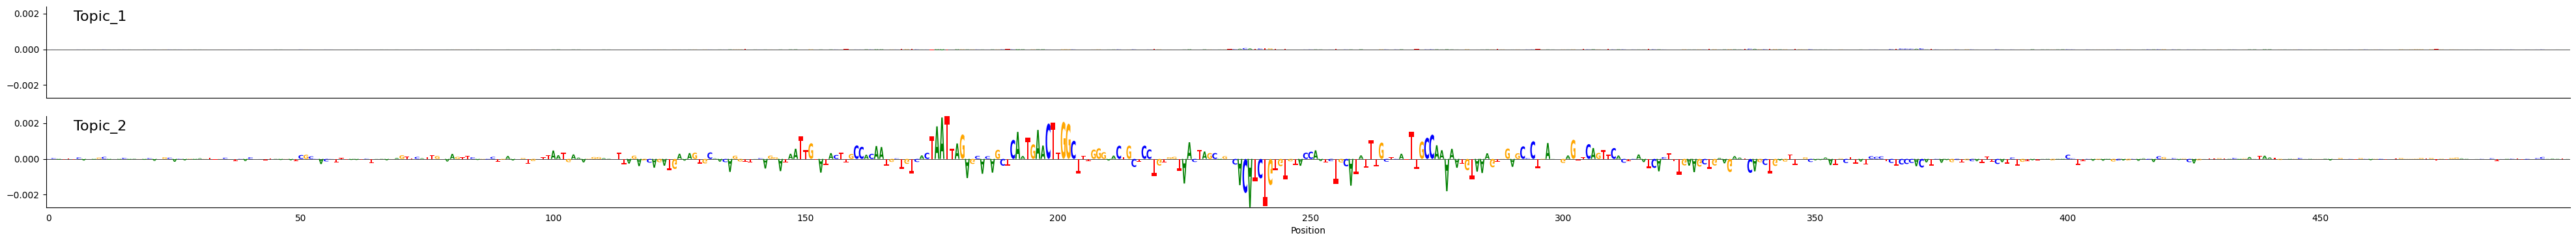

In [58]:
crested.pl.contribution_scores(
    scores, one_hot_encoded_sequences, class_names=list(adata.obs_names)[0:2]
)

## Plotting

TO DO